# Test Prioritized Dueling-DQN

In [1]:
import math
import torch
import torch.nn as nn
from torch.optim import Adam
import gym
import random
import numpy as np

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
USE_CUDA = torch.cuda.is_available()
device = 'cuda' if USE_CUDA else 'cpu'
device = torch.device(device)

In [4]:
def plot(frame_idx, rewards, losses):
    %matplotlib inline
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

## Network and Loss Definitions

In [5]:
class QNetwork(nn.Module):
    def __init__(self, input_size, num_actions):
        self.num_actions = num_actions
        super().__init__()
        self.fc_common = nn.Sequential(nn.Linear(input_size, 128),
                                nn.ReLU(),
                                nn.Linear(128, 128),
                                nn.ReLU())
        self.value = nn.Linear(128, 1)
        self.advantange = nn.Linear(128, num_actions)
                                
    def forward(self, x):
        x = self.fc_common(x)
        val, adv = self.value(x), self.advantange(x)
        return val, adv
    
    def get_value(self, state):
        val = self.value(self.fc_common(state))
        return val
    
    def get_adv(self, state):
        adv = self.advantange(self.fc_common(state))
        return adv
    
    def get_state_action_value(self, state, action):
        val, adv = self.forward(state)
        state_action_adv = torch.gather(
            adv, 1,
            action.long().unsqueeze(-1)
        )
        state_action_values = val + (state_action_adv - adv.mean(dim=1).unsqueeze(-1))
        return state_action_values
    
    def act(self, state, eps):
        if np.random.random() < eps:
            return np.random.randint(self.num_actions)
        return torch.argmax(self.get_adv(state)).item()

In [6]:
class QCNN(nn.Module):
    def __init__(self, input_size, num_actions):
        self.num_actions = num_actions
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.ReLU()
        )
        self.fc_size = self._get_fc_size()
        self.fc_common = nn.Sequential(nn.Linear(self.fc_size, 128),
                                nn.ReLU(),
                                nn.Linear(128, 128))
        self.value = nn.Linear(128, 1)
        self.advantange = nn.Linear(128, num_actions)
    
    def forward(self, x):
        x = self.conv(x)
        x = x.reshape(-1, self.fc_size)
        x = self.fc_common(x)
        val, adv = self.value(x), self.advantange(x)
        return val, adv    
    
    def get_value(self, state):
        x = self.conv(state)
        x = x.reshape(-1, self.fc_size)
        val = self.value(self.fc_common(x))
        return val
    
    def get_adv(self, state):
        x = self.conv(state)
        x = x.reshape(-1, self.fc_size)
        adv = self.advantange(self.fc_common(x))
        return adv
    
    def get_state_action_value(self, state, action):
        val, adv = self.forward(state)
        state_action_adv = torch.gather(
            adv, 1,
            action.long().unsqueeze(-1)
        )
        state_action_values = val + (state_action_adv - adv.mean(dim=1).unsqueeze(-1))
        return state_action_values
    
    def act(self, state, eps):
        if np.random.random() < eps:
            return np.random.randint(self.num_actions)
        return torch.argmax(self.get_adv(state)).item()

    def _get_fc_size(self, width=48, height=48):
        t = torch.rand((1, 1, height, width))
        return self.conv(t).reshape(-1).shape[0]

In [7]:
def synchronize_nets(from_net, to_net):
    to_net.load_state_dict(from_net.state_dict())

In [10]:
def prioritized_dueling_td_loss(online_net, target_net, batch, memory_size, beta=0.7, gamma=0.95):
    priorities, states, actions, rewards, dones, next_states = map(
        lambda arr: torch.as_tensor(arr, device=device, dtype=torch.float32), 
        batch
    )    
    
    state_action_values = online_net.get_state_action_value(states, actions)
    
    best_online_actions = torch.argmax(online_net.get_adv(next_states), dim=1)
    
    target_state_action_values = target_net.get_state_action_value(next_states, best_online_actions)
    target_state_action_values *= 1.0 - dones.float().unsqueeze(-1)
    
    expected_state_action_values = rewards.unsqueeze(-1) + gamma * target_state_action_values
        
    td_error = expected_state_action_values - state_action_values
    
    imp_samp_weights = (1/memory_size) * (1/priorities)
    imp_samp_weights /= torch.max(imp_samp_weights)
    imp_samp_weights = torch.pow(imp_samp_weights, beta)
    loss = (td_error).pow(2).mean()
    
    return td_error, loss

In [58]:
from crar.experience import PrioritizedReplayBuffer, TDExperience
from crar.utils import compute_eps

def play_step(replay_buffer, state, qnet, env, step_number, 
              eps_start=1.0, eps_end=0.01, eps_last_frame=1000):
    eps = compute_eps(step_number, eps_start, eps_end, eps_last_frame)
    print(eps)
    action = qnet.act(
        torch.as_tensor(np.expand_dims(state, 0), device=device).float(),
        eps
    )
    next_state, reward, done, _ = env.step(action)
    # States that are experienced for the first time have highest priority
    exp = TDExperience([-1e5, state, action, reward, done, next_state])
    replay_buffer.push(exp)
    
    return next_state, reward, done

In [59]:
def populate_warm_start(size, replay_buffer, qnet, env, eps_start=1.0, 
                        eps_end=0.001, eps_last_frame=1000):
    state = env.reset()
    for _ in range(size):
        next_state, reward, done =\
            play_step(replay_buffer, state, qnet, env, 0)
        state = next_state
        if done:
            state = env.reset()

## CartPole

In [13]:
online_net = QNetwork(4, 2).to(device)
target_net = QNetwork(4, 2).to(device)

In [14]:
REPLAY_SIZE = 500
MAX_EP_LEN = 200
BATCH_SIZE = 32
SYNC_INTERVAL = 100
PLOT_INTERVAL = 100
TOTAL_STEPS = 2000
GRAD_CLIP = 10.0
WARM_START_SIZE = 1000

In [15]:
replay_buffer = PrioritizedReplayBuffer(REPLAY_SIZE, sort_interval=64)

In [16]:
from crar.environments import TimeLimit

env_id = "CartPole-v0"
env = gym.make(env_id)
env = TimeLimit(env, MAX_EP_LEN)

/home/aayn/miniconda3/envs/spinningup/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [17]:
populate_warm_start(WARM_START_SIZE, replay_buffer, online_net, env)

In [18]:
optimizer = torch.optim.Adam(online_net.parameters(), lr=5e-4)

In [21]:
def train_loop():
    state = env.reset()
    ep_rewards_list = []
    losses_list = []
    episode_reward = 0
    state = env.reset()
    for step_num in range(1, TOTAL_STEPS + 1):
        if len(replay_buffer) > BATCH_SIZE:
            batch = replay_buffer.sample(BATCH_SIZE)
            td_error, loss = prioritized_dueling_td_loss(online_net, target_net, batch, len(replay_buffer))
            replay_buffer.update_priorities(td_error)
            losses_list.append(loss)
            optimizer.zero_grad()
            loss.backward()
            if GRAD_CLIP > 0:
                nn.utils.clip_grad_norm_(online_net.parameters(), GRAD_CLIP)
            optimizer.step()
        
        if step_num % SYNC_INTERVAL == 0:
            synchronize_nets(online_net, target_net)
        
        next_state, reward, done =\
            play_step(replay_buffer, state, online_net, env, step_num)
        episode_reward += reward
        state = next_state
        if done:
            ep_rewards_list.append(episode_reward)
            episode_reward = 0
            state = env.reset()
        if step_num % PLOT_INTERVAL == 0:
            plot(step_num, ep_rewards_list, losses_list)    
            

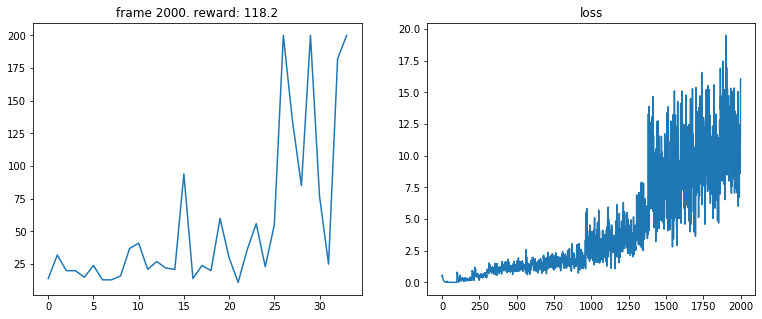

In [22]:
train_loop()

## Maze v1

In [50]:
from crar.wrappers import make_atari, wrap_deepmind, wrap_pytorch
from crar.environments import *
env_id = "SimpleMaze-v1"
env = gym.make(env_id)
# env = make_atari(env_id)
# env = wrap_deepmind(env)
# env = wrap_pytorch(env)

In [51]:
env.observation_space

In [52]:
online_net = QCNN((env.observation_space), 4).to(device)
target_net = QCNN((env.observation_space), 4).to(device)

In [53]:
REPLAY_SIZE = 10000
BATCH_SIZE = 32
SYNC_INTERVAL = 200
PLOT_INTERVAL = 100
TOTAL_STEPS = 1400000
GRAD_CLIP = 10.0
WARM_START_SIZE = 2000
EPS_LAST_FRAME = 5000

In [54]:
optimizer = torch.optim.Adam(online_net.parameters(), lr=5e-4)

In [55]:
replay_buffer = PrioritizedReplayBuffer(REPLAY_SIZE, sort_interval=64)

In [56]:
populate_warm_start(WARM_START_SIZE, replay_buffer, online_net, env)    

In [60]:
def train_loop():
    state = env.reset()
    ep_rewards_list = []
    losses_list = []
    episode_reward = 0
    state = env.reset()
    for step_num in range(1, TOTAL_STEPS + 1):
        if len(replay_buffer) > BATCH_SIZE:
            batch = replay_buffer.sample(BATCH_SIZE)
            td_error, loss = prioritized_dueling_td_loss(online_net, target_net, batch, len(replay_buffer))
            replay_buffer.update_priorities(td_error)
            losses_list.append(loss)
            optimizer.zero_grad()
            loss.backward()
            if GRAD_CLIP > 0:
                nn.utils.clip_grad_norm_(online_net.parameters(), GRAD_CLIP)
            optimizer.step()
        
        if step_num % SYNC_INTERVAL == 0:
            synchronize_nets(online_net, target_net)
        
        next_state, reward, done =\
            play_step(replay_buffer, state, online_net, env, step_num)
        episode_reward += reward
        state = next_state
        if done:
            ep_rewards_list.append(episode_reward)
            episode_reward = 0
            state = env.reset()
        if step_num % PLOT_INTERVAL == 0:
            plot(step_num, ep_rewards_list, losses_list)    
            

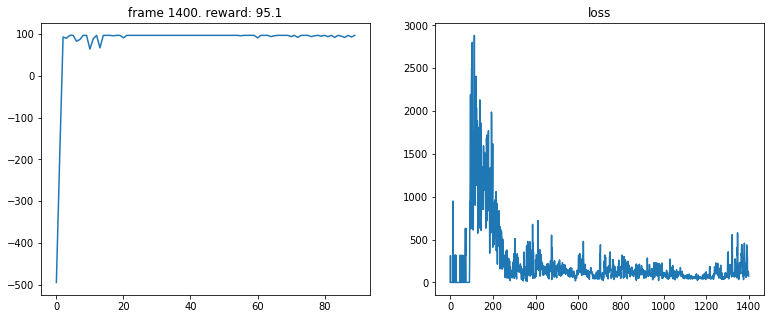

0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01
0.01


KeyboardInterrupt: 

In [61]:
train_loop()

## Atari Pong

In [20]:
from crar.wrappers import make_atari, wrap_deepmind, wrap_pytorch
env_id = "PongNoFrameskip-v4"
env = make_atari(env_id)
env = wrap_deepmind(env)
env = wrap_pytorch(env)

In [21]:
env.observation_space

Box(1, 84, 84)

In [22]:
online_net = QCNN((env.observation_space), 2).to(device)
target_net = QCNN((env.observation_space), 2).to(device)

In [27]:
REPLAY_SIZE = 100000
BATCH_SIZE = 128
SYNC_INTERVAL = 1000
PLOT_INTERVAL = 100
TOTAL_STEPS = 1400000
GRAD_CLIP = 10.0
WARM_START_SIZE = 20000
EPS_LAST_FRAME = 50000

In [28]:
optimizer = torch.optim.Adam(online_net.parameters(), lr=5e-4)

In [29]:
replay_buffer = UniformReplayBuffer(REPLAY_SIZE)

In [30]:
populate_warm_start(WARM_START_SIZE, replay_buffer, online_net, env)

In [31]:
def train_loop():
    state = env.reset()
    ep_rewards_list = []
    losses_list = []
    episode_reward = 0
    state = env.reset()
    for step_num in range(1, TOTAL_STEPS + 1):
        if len(replay_buffer) > BATCH_SIZE:
            batch = replay_buffer.sample(BATCH_SIZE)
            loss = dueling_dqn_td_loss(online_net, target_net, batch)
            losses_list.append(loss)
            optimizer.zero_grad()
            loss.backward()
            if GRAD_CLIP > 0:
                nn.utils.clip_grad_norm_(online_net.parameters(), GRAD_CLIP)
            optimizer.step()
        
        if step_num % SYNC_INTERVAL == 0:
            synchronize_nets(online_net, target_net)
        
        next_state, reward, done =\
            play_step(replay_buffer, state, online_net, env, step_num, eps_last_frame=EPS_LAST_FRAME)
        episode_reward += reward
        state = next_state
        if done:
            ep_rewards_list.append(episode_reward)
            episode_reward = 0
            state = env.reset()
        if step_num % PLOT_INTERVAL == 0:
            plot(step_num, ep_rewards_list, losses_list)    
            

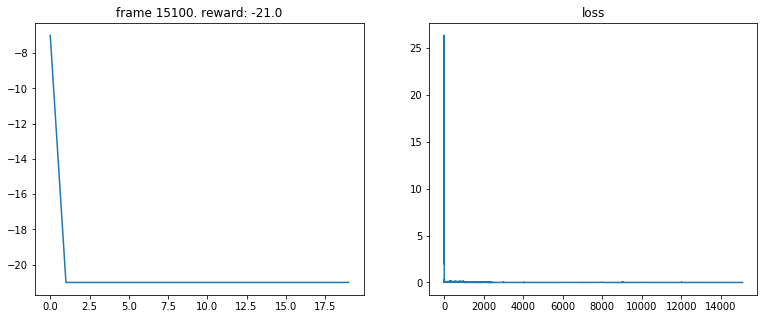

KeyboardInterrupt: 

In [32]:
train_loop()